# Mapper limpio con análisis

## Librerías

In [1]:
import pandas as pd
import numpy as np
import random

import plotly
import requests
from bs4 import BeautifulSoup
import ruptures as rpt
import yfinance as yf

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import kmapper as km
import subprocess
import sys
import networkx as nx
subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "nbformat>=4.2.0"])
import sklearn.cluster

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



#### Funciones de docs en repositorio

from Funciones import calculate_metrics


## Recolección Datos

### Sacar tickers

In [2]:
START_DATE = "2025-01-01"
END_DATE = "2025-10-08"
AN_DATE = "2025-07-08"

# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petición con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK.B']
Found 503 weights
First 10 weights: ['7.28%', '6.32%', '6.13%', '3.81%', '2.98%', '2.76%', '2.60%', '2.43%', '2.40%', '1.77%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'GOOG', 'TSLA', 'BRK-B']


### Descargar información financiera

In [74]:
# =======================================================
# 📊 RECOPILACIÓN DE INFORMACIÓN FUNDAMENTAL DE TICKERS
# =======================================================

print("🔍 Recopilando información detallada de todos los tickers del S&P 500...")
print("=" * 80)

ticker_info_db = {}
failed_tickers = []


for idx, ticker in enumerate(tickers, 1):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Extraer información relevante
        ticker_info_db[ticker] = {
            # Información básica
            'sector': info.get('sector', 'Unknown'),
            'industry': info.get('industry', 'Unknown'),
            'market_cap': info.get('marketCap', None),
            'country': info.get('country', 'Unknown'),
            'full_name': info.get('longName', ticker),
            
            # Métricas de valoración
            'pe_ratio': info.get('trailingPE', None),
            'forward_pe': info.get('forwardPE', None),
            'peg_ratio': info.get('pegRatio', None),
            'price_to_book': info.get('priceToBook', None),
            'price_to_sales': info.get('priceToSalesTrailing12Months', None),
            'enterprise_value': info.get('enterpriseValue', None),
            'ev_to_ebitda': info.get('enterpriseToEbitda', None),
            
            # Dividendos
            'dividend_yield': info.get('dividendYield', None),
            'dividend_rate': info.get('dividendRate', None),
            'payout_ratio': info.get('payoutRatio', None),
            'five_year_avg_dividend_yield': info.get('fiveYearAvgDividendYield', None),
            
            # Rentabilidad
            'profit_margins': info.get('profitMargins', None),
            'operating_margins': info.get('operatingMargins', None),
            'gross_margins': info.get('grossMargins', None),
            'roe': info.get('returnOnEquity', None),
            'roa': info.get('returnOnAssets', None),
            
            # Crecimiento
            'revenue_growth': info.get('revenueGrowth', None),
            'earnings_growth': info.get('earningsGrowth', None),
            'earnings_quarterly_growth': info.get('earningsQuarterlyGrowth', None),
            
            # Riesgo y volatilidad
            'beta': info.get('beta', None),
            '52week_high': info.get('fiftyTwoWeekHigh', None),
            '52week_low': info.get('fiftyTwoWeekLow', None),
            '52week_change': info.get('52WeekChange', None),
            
            # Liquidez y deuda
            'current_ratio': info.get('currentRatio', None),
            'quick_ratio': info.get('quickRatio', None),
            'debt_to_equity': info.get('debtToEquity', None),
            'total_debt': info.get('totalDebt', None),
            'total_cash': info.get('totalCash', None),
            
            # Analistas y recomendaciones
            'recommendation': info.get('recommendationKey', 'Unknown'),
            'recommendation_mean': info.get('recommendationMean', None),
            'target_mean_price': info.get('targetMeanPrice', None),
            'target_high_price': info.get('targetHighPrice', None),
            'target_low_price': info.get('targetLowPrice', None),
            'number_of_analysts': info.get('numberOfAnalystOpinions', None),
            
            # Información adicional
            'employees': info.get('fullTimeEmployees', None),
            'exchange': info.get('exchange', 'Unknown'),
            'quote_type': info.get('quoteType', 'Unknown'),
        }
        
        
    except Exception as e:
        failed_tickers.append(ticker)
        ticker_info_db[ticker] = {
            'sector': 'Unknown',
            'industry': 'Unknown',
            'error': str(e)
        }

print(f"\n{'='*80}")
print(f"📊 RESUMEN DE RECOPILACIÓN:")
if failed_tickers:
    print(f"   Tickers fallidos: {', '.join(failed_tickers[:10])}{'...' if len(failed_tickers) > 10 else ''}")

# Crear DataFrame para análisis fácil
ticker_info_df = pd.DataFrame.from_dict(ticker_info_db, orient='index')

print(f"\n DataFrame de información creado: {ticker_info_df.shape}")


# Guardar en CSV para uso posterior
ticker_info_df.to_csv('sp500_ticker_info_database.csv')
print("\n Base de datos guardada en 'sp500_ticker_info_database.csv'")

# Mostrar primeras filas
print("\n Primeras filas de la base de datos:")
display(ticker_info_df.head(10))

🔍 Recopilando información detallada de todos los tickers del S&P 500...

📊 RESUMEN DE RECOPILACIÓN:

 DataFrame de información creado: (503, 42)

 Base de datos guardada en 'sp500_ticker_info_database.csv'

 Primeras filas de la base de datos:


,sector,industry,market_cap,country,full_name,pe_ratio,forward_pe,peg_ratio,price_to_book,price_to_sales,...,total_cash,recommendation,recommendation_mean,target_mean_price,target_high_price,target_low_price,number_of_analysts,employees,exchange,quote_type
NVDA,Technology,Semiconductors,4378321223680,United States,NVIDIA Corporation,51.233620,43.648060,None,43.722343,26.500269,...,5.679100e+10,strong_buy,1.37500,218.51369,320.0,100.0,57.0,36000.0,NMS,EQUITY
MSFT,Technology,Software - Infrastructure,3816410578944,United States,Microsoft Corporation,37.586384,34.343143,None,11.112242,13.546630,...,9.456500e+10,strong_buy,1.25862,620.73690,710.0,483.0,51.0,228000.0,NMS,EQUITY
AAPL,Technology,Consumer Electronics,3700302807040,United States,Apple Inc.,37.836113,30.004812,None,56.271717,9.055498,...,5.537200e+10,buy,2.08333,248.12030,310.0,175.0,41.0,150000.0,NMS,EQUITY
AMZN,Consumer Cyclical,Internet Retail,2299035123712,United States,"Amazon.com, Inc.",32.861282,35.052032,None,6.884801,3.431201,...,9.318000e+10,strong_buy,1.29412,266.56450,306.0,230.0,62.0,1546000.0,NMS,EQUITY
META,Communication Services,Internet Content & Information,1802587209728,United States,"Meta Platforms, Inc.",26.026478,28.361660,None,9.254889,10.081359,...,4.707100e+10,strong_buy,1.41176,868.25696,1086.0,658.0,62.0,75945.0,NMS,EQUITY
AVGO,Technology,Semiconductors,1659108458496,United States,Broadcom Inc.,90.316190,56.941650,None,5.932524,27.685953,...,1.110500e+10,strong_buy,1.27660,386.67618,460.0,218.0,42.0,37000.0,NMS,EQUITY
GOOGL,Communication Services,Internet Content & Information,3040066404352,United States,Alphabet Inc.,26.762260,28.016740,None,8.372411,8.185446,...,9.514800e+10,buy,1.52239,249.05357,340.0,185.0,53.0,187103.0,NMS,EQUITY
GOOG,Communication Services,Internet Content & Information,3039138938880,United States,Alphabet Inc.,26.834755,28.124023,None,8.395091,8.182949,...,9.514800e+10,buy,1.51471,242.20557,285.0,185.0,18.0,187103.0,NMS,EQUITY
TSLA,Consumer Cyclical,Auto Manufacturers,1446939459584,United States,"Tesla, Inc.",260.568880,134.305560,None,18.145615,15.605474,...,3.678200e+10,hold,2.52174,366.38257,600.0,120.0,39.0,125665.0,NMS,EQUITY
BRK-B,Financial Services,Insurance - Diversified,1070655930368,United States,Berkshire Hathaway Inc.,17.022978,24.720620,None,0.001069,2.892484,...,3.440910e+11,buy,2.00000,519.66670,593.0,479.0,3.0,392400.0,NYQ,EQUITY


### Descargar Precios historicos

In [102]:
# -----------------------------
# Descargar precios históricos
# -----------------------------
all_tickers_data = yf.download(tickers, start=START_DATE, end=END_DATE, auto_adjust=True)['Close']
all_tickers_data = all_tickers_data.dropna(axis=1)  # eliminar columnas con datos faltantes

# DIVIDIR EN DOS PERIODOS
# Período de análisis: desde START_DATE hasta AN_DATE
analysis_data = all_tickers_data.loc[START_DATE:AN_DATE]
tickers_data = analysis_data  # Datos para entrenamiento/análisis

# Período de validación: desde AN_DATE hasta END_DATE
validation_data = all_tickers_data.loc[AN_DATE:END_DATE]  # Datos para validación

print(f"✅ Datos descargados:")
print(f"   📊 Total: {all_tickers_data.shape} (desde {START_DATE} hasta {END_DATE})")
print(f"   📊 Período de análisis: {tickers_data.shape} (desde {START_DATE} hasta {AN_DATE})")
print(f"   📊 Período de validación: {validation_data.shape} (desde {AN_DATE} hasta {END_DATE})")

[*********************100%***********************]  503 of 503 completed

✅ Datos descargados:
   📊 Total: (191, 503) (desde 2025-01-01 hasta 2025-10-08)
   📊 Período de análisis: (127, 503) (desde 2025-01-01 hasta 2025-07-08)
   📊 Período de validación: (65, 503) (desde 2025-07-08 hasta 2025-10-08)


## Analisis inicial

In [5]:
# =======================================================
# 📈 ESTADÍSTICAS GENERALES DE LA BASE DE DATOS
# =======================================================

print("\n📈 ESTADÍSTICAS GENERALES DEL S&P 500:")
print("=" * 80)

# Distribución por Sector
print("\n🏢 DISTRIBUCIÓN POR SECTOR:")
sector_counts = ticker_info_df['sector'].value_counts()
for sector, count in sector_counts.items():
    pct = (count / len(ticker_info_df)) * 100
    print(f"   {sector:30s}: {count:3d} empresas ({pct:5.1f}%)")

# Top 10 Industrias
print("\n🏭 TOP 10 INDUSTRIAS:")
industry_counts = ticker_info_df['industry'].value_counts().head(10)
for industry, count in industry_counts.items():
    print(f"   {industry:50s}: {count:2d} empresas")

# Distribución por País
print("\n🌍 TOP 10 PAÍSES:")
country_counts = ticker_info_df['country'].value_counts().head(10)
for country, count in country_counts.items():
    pct = (count / len(ticker_info_df)) * 100
    print(f"   {country:30s}: {count:3d} empresas ({pct:5.1f}%)")

# Estadísticas de métricas financieras
print("\n💰 ESTADÍSTICAS DE MÉTRICAS FINANCIERAS (Medianas):")
financial_stats = {
    'Market Cap (Billones)': ticker_info_df['market_cap'].median() / 1e9 if ticker_info_df['market_cap'].notna().any() else None,
    'P/E Ratio': ticker_info_df['pe_ratio'].median(),
    'Beta': ticker_info_df['beta'].median(),
    'ROE (%)': ticker_info_df['roe'].median() * 100 if ticker_info_df['roe'].notna().any() else None,
    'Profit Margin (%)': ticker_info_df['profit_margins'].median() * 100 if ticker_info_df['profit_margins'].notna().any() else None,
    'Debt/Equity': ticker_info_df['debt_to_equity'].median(),
    'Dividend Yield (%)': ticker_info_df['dividend_yield'].median() * 100 if ticker_info_df['dividend_yield'].notna().any() else None,
}

for metric, value in financial_stats.items():
    if value is not None and not np.isnan(value):
        print(f"   {metric:25s}: {value:8.2f}")

# Empresas más grandes por Market Cap
print("\n🏆 TOP 10 EMPRESAS POR MARKET CAP:")
top_companies = ticker_info_df.nlargest(10, 'market_cap')[['full_name', 'sector', 'market_cap']]
for idx, (ticker, row) in enumerate(top_companies.iterrows(), 1):
    market_cap_b = row['market_cap'] / 1e9 if pd.notna(row['market_cap']) else 0
    print(f"   {idx:2d}. {ticker:5s} - {row['full_name'][:40]:40s} | ${market_cap_b:6.1f}B | {row['sector']}")

print(f"\n{'='*80}")
print("✅ Estadísticas generales completadas")


📈 ESTADÍSTICAS GENERALES DEL S&P 500:

🏢 DISTRIBUCIÓN POR SECTOR:
   Technology                    :  81 empresas ( 16.1%)
   Industrials                   :  72 empresas ( 14.3%)
   Financial Services            :  69 empresas ( 13.7%)
   Healthcare                    :  60 empresas ( 11.9%)
   Consumer Cyclical             :  55 empresas ( 10.9%)
   Consumer Defensive            :  37 empresas (  7.4%)
   Real Estate                   :  31 empresas (  6.2%)
   Utilities                     :  31 empresas (  6.2%)
   Communication Services        :  25 empresas (  5.0%)
   Energy                        :  22 empresas (  4.4%)
   Basic Materials               :  20 empresas (  4.0%)

🏭 TOP 10 INDUSTRIAS:
   Utilities - Regulated Electric                    : 23 empresas
   Software - Application                            : 17 empresas
   Specialty Industrial Machinery                    : 17 empresas
   Software - Infrastructure                         : 15 empresas
   Semiconductor

## Funciones

### Transfromaciones

### Visualizaciones

In [6]:

def plot_comparacion_clusters(G, ticker_names, metrics_df, title="Mapper sin nombre"):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

    # Gráfico 1: Sharpe vs Volatilidad coloreado por nodos
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax1.scatter(node_data['volatility'], node_data['sharpe_ratio'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)
        
        # Agregar etiquetas de tickers cerca de los puntos
        for idx, ticker in enumerate(tickers_in_node):
            if len(tickers_in_node) <= 5:  # Solo si hay pocos tickers para evitar saturación
                ax1.annotate(ticker, (node_data['volatility'].iloc[idx], node_data['sharpe_ratio'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

    ax1.set_xlabel('Volatilidad')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Clusters Mapper: Sharpe vs Volatilidad\n(con nombres de tickers)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Retorno vs Drawdown coloreado por nodos
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        ax2.scatter(node_data['max_drawdown'], node_data['total_return'], 
                c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)

    ax2.set_xlabel('Max Drawdown')
    ax2.set_ylabel('Retorno Total')
    ax2.set_title('Clusters Mapper: Retorno vs Drawdown')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax2.grid(True, alpha=0.3)



    # Gráfico 3: Volatilidad vs Retorno
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax3.scatter(node_data['volatility'], node_data['total_return'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=100)
        
        # Agregar etiquetas de tickers (solo si hay pocos)
        if len(tickers_in_node) <= 5:
            for idx, ticker in enumerate(tickers_in_node):
                ax3.annotate(ticker, 
                            (node_data['volatility'].iloc[idx], node_data['total_return'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)

    ax3.set_xlabel('Volatilidad', fontsize=12)
    ax3.set_ylabel('Retorno Total', fontsize=12)
    ax3.set_title('⚖️ Volatilidad vs Retorno Total\n(Frontera eficiente: Alto retorno, baja volatilidad)', fontsize=13, fontweight='bold')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    # Gráfico 4: Volatilidad vs Drawdown
    for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
        node_data = metrics_df.iloc[node_indices]
        tickers_in_node = [ticker_names[j] for j in node_indices]
        
        scatter = ax4.scatter(node_data['volatility'], node_data['max_drawdown'], 
                            c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=100)
        
        # Agregar etiquetas de tickers (solo si hay pocos)
        if len(tickers_in_node) <= 5:
            for idx, ticker in enumerate(tickers_in_node):
                ax4.annotate(ticker, 
                            (node_data['volatility'].iloc[idx], node_data['max_drawdown'].iloc[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=7, alpha=0.8)

    ax4.set_xlabel('Volatilidad', fontsize=12)
    ax4.set_ylabel('Max Drawdown (negativo)', fontsize=12)
    ax4.set_title('🎯 Volatilidad vs Max Drawdown\n(Menor volatilidad y menor drawdown = Mejor)', fontsize=13, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)

    plt.suptitle(f'🔬 ANÁLISIS MULTIDIMENSIONAL: {title}', 
                fontsize=16, fontweight='bold', y=1.00)



    plt.tight_layout()
    plt.show()

## Creación

### Preparación

In [7]:
# =======================================================
# CREAR SUBCARPETA PARA VISUALIZACIONES
# =======================================================

import os

# Crear la subcarpeta para todas las visualizaciones
output_folder = 'visualizaciones_mapper_indice'
os.makedirs(output_folder, exist_ok=True)
print(f"📁 Subcarpeta creada: {output_folder}/")
print(f"🌐 Todas las visualizaciones HTML se guardarán en esta carpeta")

📁 Subcarpeta creada: visualizaciones_mapper_indice/
🌐 Todas las visualizaciones HTML se guardarán en esta carpeta


In [8]:
# Sacamos métricas de cada ticker

financial_metrics = {}
print("\n🔄 Calculando métricas financieras...")
for ticker in tickers_data.columns:
    try:
        prices = tickers_data[ticker].dropna()
        returns = prices.pct_change().dropna()
        
        # Métricas básicas
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        volatility = returns.std() * np.sqrt(252)  # Anualizada
        sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        
        # Métricas de riesgo
        max_drawdown = ((prices / prices.cummax()) - 1).min()
        var_95 = returns.quantile(0.05)  # Value at Risk 95%
        skewness = returns.skew()
        kurtosis = returns.kurtosis()
        
        # Métricas de tendencia
        returns_positive_ratio = (returns > 0).mean()
        trend_slope = np.polyfit(range(len(prices)), prices.values, 1)[0]
        
        financial_metrics[ticker] = {
            'total_return': total_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'var_95': var_95,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'positive_ratio': returns_positive_ratio,
            'trend_slope': trend_slope / prices.iloc[0]  # Normalizado
        }
    except Exception as e:
        print(f"❌ Error procesando {ticker}: {e}")

# Convertir a DataFrame
metrics_df = pd.DataFrame(financial_metrics).T

# Normalizar datos
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_df.fillna(0))

# Preparar datos para KeplerMapper (usar métricas financieras)
X = metrics_scaled  # Datos normalizados que ya tenemos
ticker_names = metrics_df.index.tolist()


print(f"📊 Datos preparados: {X.shape[0]} tickers, {X.shape[1]} métricas")

# 1. Crear el mapper
mapper = km.KeplerMapper(verbose=1)




🔄 Calculando métricas financieras...
📊 Datos preparados: 503 tickers, 9 métricas
KeplerMapper(verbose=1)


### Configuraciones

In [52]:
# Configuración 1: Proyección por Sharpe
projected_data_sharpe = mapper.fit_transform(X, projection=[2])  # Sharpe ratio (índice 2)
covering = km.Cover(n_cubes=6, perc_overlap=0.5)
G = mapper.map(projected_data_sharpe, X, 
               clusterer=sklearn.cluster.KMeans(n_clusters=2),
               cover=covering)

mapper.visualize(G, 
                title='Mapper: Agrupación por Sharpe',
                color_values=metrics_df['sharpe_ratio'].values,
                color_function_name='Sharpe Ratio',
                node_color_function=np.array(['average','std','sum','max','min']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_principal_sharpe.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G['nodes'])}, Aristas: {len(G['links'])}")

..Composing projection pipeline of length 1:
	Projections: [2]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [2]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 6 hypercubes.

Created 16 edges and 12 nodes in 0:00:00.026181.


IndexError: index 251 is out of bounds for axis 0 with size 75

### Métricas de calidad del clustering (Mapper G)

In [53]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

def calculate_dunn_index(X, labels):
    """
    Calcula el índice de Dunn para medir la calidad del clustering.
    Dunn Index = min(distancia entre clusters) / max(diámetro de clusters)
    Valores más altos indican mejor separación entre clusters.
    """
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels >= 0]  # Excluir ruido (-1)
    
    if len(unique_labels) < 2:
        return 0.0
    
    # Calcular distancia mínima entre clusters
    min_inter_cluster_dist = np.inf
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            
            # Distancia mínima entre puntos de diferentes clusters
            dist = cdist(cluster_i, cluster_j, metric='euclidean')
            min_inter_cluster_dist = min(min_inter_cluster_dist, np.min(dist))
    
    # Calcular diámetro máximo de clusters (distancia máxima intra-cluster)
    max_intra_cluster_dist = 0
    for label in unique_labels:
        cluster = X[labels == label]
        if len(cluster) > 1:
            dist = cdist(cluster, cluster, metric='euclidean')
            max_intra_cluster_dist = max(max_intra_cluster_dist, np.max(dist))
    
    if max_intra_cluster_dist == 0:
        return 0.0
    
    dunn_index = min_inter_cluster_dist / max_intra_cluster_dist
    return dunn_index


# Asignar etiquetas de cluster a cada punto según el Mapper G
labels_G = np.full(len(X), -1)  # -1 significa sin asignar

for cluster_id, (node_name, node_indices) in enumerate(G['nodes'].items()):
    for idx in node_indices:
        labels_G[idx] = cluster_id

# Filtrar puntos que fueron asignados a algún cluster
assigned_mask = labels_G >= 0
X_assigned = X[assigned_mask]
labels_assigned = labels_G[assigned_mask]

print("=" * 80)
print("  MÉTRICAS DE CALIDAD DEL CLUSTERING - MAPPER G (Sharpe)")
print("=" * 80)

# Verificar que hay suficientes clusters
if len(np.unique(labels_assigned)) < 2:
    print("⚠️ No hay suficientes clusters para calcular métricas")
else:
    # 1. Silhouette Score
    silhouette = silhouette_score(X_assigned, labels_assigned)
    print(f"\n📊 Silhouette Score: {silhouette:.4f}")
    print(f"   Rango: [-1, 1] | Mejor: cercano a 1")
    print(f"   Interpretación: ", end="")
    if silhouette > 0.7:
        print("Excelente estructura de clusters")
    elif silhouette > 0.5:
        print("Buena estructura de clusters")
    elif silhouette > 0.25:
        print("Estructura de clusters moderada")
    else:
        print("Estructura de clusters débil")
    
    # 2. Calinski-Harabasz Index
    calinski = calinski_harabasz_score(X_assigned, labels_assigned)
    print(f"\n📊 Calinski-Harabasz Index: {calinski:.4f}")
    print(f"   Rango: [0, ∞) | Mejor: valores más altos")
    print(f"   Interpretación: Clusters bien definidos y separados")
    
    # 3. Dunn Index
    dunn = calculate_dunn_index(X_assigned, labels_assigned)
    print(f"\n📊 Dunn Index: {dunn:.4f}")
    print(f"   Rango: [0, ∞) | Mejor: valores más altos")
    print(f"   Interpretación: ", end="")
    if dunn > 1.0:
        print("Excelente separación entre clusters")
    elif dunn > 0.5:
        print("Buena separación entre clusters")
    elif dunn > 0.1:
        print("Separación moderada entre clusters")
    else:
        print("Separación débil entre clusters")

print(f"\n{'=' * 80}")
print(f"📈 Resumen del Mapper G:")
print(f"   • Total de nodos: {len(G['nodes'])}")
print(f"   • Puntos asignados: {np.sum(assigned_mask)} / {len(X)} ({np.sum(assigned_mask)/len(X)*100:.1f}%)")
print(f"   • Clusters únicos: {len(np.unique(labels_assigned))}")
print(f"{'=' * 80}")

  MÉTRICAS DE CALIDAD DEL CLUSTERING - MAPPER G (Sharpe)

📊 Silhouette Score: 0.0734
   Rango: [-1, 1] | Mejor: cercano a 1
   Interpretación: Estructura de clusters débil

📊 Calinski-Harabasz Index: 64.5182
   Rango: [0, ∞) | Mejor: valores más altos
   Interpretación: Clusters bien definidos y separados

📊 Dunn Index: 0.0432
   Rango: [0, ∞) | Mejor: valores más altos
   Interpretación: Separación débil entre clusters

📈 Resumen del Mapper G:
   • Total de nodos: 12
   • Puntos asignados: 503 / 503 (100.0%)
   • Clusters únicos: 11


In [54]:
# Configuración 2: Proyección por Volatilidad

projected_data_vol = mapper.fit_transform(X, projection=[1])  # Volatilidad (índice 1)
covering_vol = km.Cover(n_cubes=8, perc_overlap=0.4)
G_vol = mapper.map(projected_data_vol, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=3),
                   cover=covering_vol)

mapper.visualize(G_vol, 
                title='Mapper: Agrupación por Volatilidad',
                color_values=metrics_df['volatility'].values,
                color_function_name='Volatilidad',
                node_color_function=np.array(['average','max']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_volatilidad.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_vol['nodes'])}, Aristas: {len(G_vol['links'])}")

..Composing projection pipeline of length 1:
	Projections: [1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 8 hypercubes.

Created 26 edges and 24 nodes in 0:00:00.029413.


KeyError: 'volatility'

In [55]:
# Configuración 3: Proyección por Retorno Total

projected_data_ret = mapper.fit_transform(X, projection=[0])  # Retorno total (índice 0)
covering_ret = km.Cover(n_cubes=7, perc_overlap=0.3)
G_ret = mapper.map(projected_data_ret, X, 
                   clusterer=sklearn.cluster.DBSCAN(eps=0.5, min_samples=1),
                   cover=covering_ret)

mapper.visualize(G_ret, 
                title='Mapper: Agrupación por Retorno Total',
                node_color_function=np.array(['average','std']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_retorno_total.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_ret['nodes'])}, Aristas: {len(G_ret['links'])}")

..Composing projection pipeline of length 1:
	Projections: [0]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: [0]

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 7 hypercubes.

Created 208 edges and 677 nodes in 0:00:00.078278.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_retorno_total.html
Nodos: 677, Aristas: 208
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_retorno_total.html
Nodos: 677, Aristas: 208


In [56]:
# Configuración 4: Proyección Multi-dimensional (PCA)
projected_data_pca = mapper.fit_transform(X, projection='sum')  # Proyección suma
covering_pca = km.Cover(n_cubes=5, perc_overlap=0.6)
G_pca = mapper.map(projected_data_pca, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=2),
                   cover=covering_pca)

mapper.visualize(G_pca, 
                title='Mapper: Proyección PCA (Suma)',
                node_color_function=np.array(['min','average']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_pca_suma.html')  # Guardado en subcarpeta

..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 9)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 9) using lens shaped (503, 1)

Creating 5 hypercubes.

Created 22 edges and 10 nodes in 0:00:00.024334.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_pca_suma.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper: Proyección PCA (Suma) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13p

In [57]:
graphs={
    'Sharpe': G,
    'Volatilidad': G_vol,
    'Retorno': G_ret,
    'PCA': G_pca}


graph_names = list(graphs.keys())

categories = {ticker: ticker_info_db[ticker]['sector'] for ticker in ticker_names}
market_caps = {ticker: ticker_info_db[ticker]['market_cap'] for ticker in ticker_names}

## Indices

### Exraer información de mappers

In [58]:
"""
Analiza todos los clusters encontrados en los diferentes archivos Mapper
"""
print("  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER")
print("=" * 60)

# Diccionario para almacenar todos los clusters encontrados
all_clusters = {}
# 1. Extraer clusters del grafo G (Sharpe Ratio)
print(f"\n Extrayendo clusters del análisis por Sharpe Ratio (G):")
print(f"Total de nodos: {len(G['nodes'])}")

for i, (node_name, node_indices) in enumerate(G['nodes'].items()):
    if len(node_indices) >= 2:  # Solo clusters con al menos 2 tickers
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"Sharpe_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Sharpe Ratio',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

# 2. Extraer clusters del grafo G_vol (Volatilidad)
print(f"\n Extrayendo clusters del análisis por Volatilidad (G_vol):")
print(f"Total de nodos: {len(G_vol['nodes'])}")

for i, (node_name, node_indices) in enumerate(G_vol['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"Vol_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Volatilidad',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

# 3. Extraer clusters del grafo G_ret (Retorno)
print(f"\n Extrayendo clusters del análisis por Retorno (G_ret):")
print(f"Total de nodos: {len(G_ret['nodes'])}")

for i, (node_name, node_indices) in enumerate(G_ret['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"Return_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Retorno Total',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

# 4. Extraer clusters del grafo G_pca (PCA)
print(f"\n🔬 Extrayendo clusters del análisis PCA (G_pca):")
print(f"Total de nodos: {len(G_pca['nodes'])}")

for i, (node_name, node_indices) in enumerate(G_pca['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [ticker_names[idx] for idx in node_indices]
        cluster_name = f"PCA_Cluster_{i+1}"
        all_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'PCA',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")

print(f"\n📋 RESUMEN: {len(all_clusters)} clusters encontrados en total")

  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER

 Extrayendo clusters del análisis por Sharpe Ratio (G):
Total de nodos: 12
     Sharpe_Cluster_2: ['ACN', 'CAG', 'CLX', 'CMG', 'CPB', 'CPRT', 'CRM', 'DECK', 'DOW', 'EPAM', 'FDS', 'FI', 'GDDY', 'HRL', 'IFF', 'KMX', 'LULU', 'OKE', 'STZ', 'TGT'] (20 tickers)
     Sharpe_Cluster_3: ['ACN', 'ADBE', 'AMCR', 'APO', 'ARE', 'AVB', 'AVY', 'BALL', 'BF-B', 'BMY', 'BRO', 'CAG', 'CARR', 'CDW', 'CHD', 'CL', 'CLX', 'CMCSA', 'CMG', 'COO', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRM', 'CTSH', 'DHR', 'DOV', 'DVA', 'DXCM', 'EIX', 'EOG', 'EQIX', 'EQR', 'ERIE', 'FDX', 'FIS', 'FRT', 'FTV', 'GIS', 'GWW', 'HON', 'HPQ', 'HRL', 'HSIC', 'IEX', 'IFF', 'INVH', 'IP', 'IR', 'ISRG', 'JBHT', 'JKHY', 'KDP', 'KHC', 'KMB', 'KVUE', 'LII', 'LYB', 'MAA', 'MKC', 'MRK', 'NOW', 'ODFL', 'OKE', 'PAYX', 'PCG', 'PG', 'POOL', 'PPG', 'PRU', 'PYPL', 'RVTY', 'SBUX', 'SW', 'TAP', 'TECH', 'TGT', 'TSN', 'TYL', 'UDR', 'VRSK', 'VTRS', 'WAT', 'WY', 'ZTS'] (86 tickers)
     Sharpe_Cluster_4: ['AKAM', 'ALGN',

### Nevos indices

### Pesos

In [59]:
# Convert market_caps dict to pandas Series
market_caps_series = pd.Series(market_caps)

# Mostrar muestra del DataFrame
print(f"\n📋 Muestra de las capitalizaciones:")
print(market_caps_series.head(10))
print(f"\n📊 Estadísticas de las capitalizaciones:")
print(f"   💰 Capitalización promedio: ${market_caps_series.mean():,.0f}")
print(f"   📈 Capitalización máxima: ${market_caps_series.max():,.0f}")
print(f"   📉 Capitalización mínima: ${market_caps_series.min():,.0f}")


📋 Muestra de las capitalizaciones:
A         39590830080
AAPL    3700302807040
ABBV     399630794752
ABNB      76076400640
ABT      225302413312
ACGL      33429340160
ACN      148653490176
ADBE     138401726464
ADI      117159182336
ADM       30451838976
dtype: int64

📊 Estadísticas de las capitalizaciones:
   💰 Capitalización promedio: $126,513,818,809
   📈 Capitalización máxima: $4,378,321,223,680
   📉 Capitalización mínima: $6,522,856,448


### Funciones creación indices

In [60]:
def create_market_cap_weighted_index(cluster_tickers, data, market_caps_dict, start_value=1):
    """
    Crea un índice ponderado por capitalización de mercado para un cluster específico.
    
    Parámetros:
    -----------
    cluster_tickers : list
        Lista de tickers del cluster
    data : pd.DataFrame
        DataFrame con precios históricos (tickers como columnas)
    market_caps_dict : dict
        Diccionario con {ticker: market_cap}
    start_value : float
        Valor inicial del índice (default: 1)
    
    Retorna:
    --------
    index_series : pd.Series
        Serie temporal del índice
    weights : dict
        Diccionario con los pesos de cada ticker
    """
    # Filtrar tickers que existen tanto en data como en market_caps
    valid_tickers = [t for t in cluster_tickers if t in data.columns and t in market_caps_dict]
    
    if not valid_tickers:
        print(f"⚠️  No hay tickers válidos en el cluster")
        return None, None
    
    # Calcular capitalización total del cluster
    total_market_cap = sum([market_caps_dict[ticker] for ticker in valid_tickers])
    
    # Calcular pesos de cada ticker (capitalización / capitalización total)
    weights = {ticker: market_caps_dict[ticker] / total_market_cap for ticker in valid_tickers}
    
    # Crear el índice
    index_series = pd.Series(0, index=data.index)
    
    for ticker, weight in weights.items():
        # Normalizar precios del ticker al valor inicial
        ticker_prices = data[ticker].dropna()
        if len(ticker_prices) > 0:
            ticker_normalized = (ticker_prices / ticker_prices.iloc[0]) * start_value
            # Agregar al índice con su peso
            index_series = index_series.add(ticker_normalized * weight, fill_value=0)
    
    return index_series, weights


def create_all_cluster_indices(all_clusters, data, market_caps_dict, start_value=1):
    """
    Crea índices ponderados por capitalización para todos los clusters.
    
    Parámetros:
    -----------
    all_clusters : dict
        Diccionario con todos los clusters {cluster_name: {tickers: [...], ...}}
    data : pd.DataFrame
        DataFrame con precios históricos
    market_caps_dict : dict
        Diccionario con {ticker: market_cap}
    start_value : float
        Valor inicial del índice (default: 1)
    
    Retorna:
    --------
    cluster_indices : dict
        Diccionario con {cluster_name: {index: serie, weights: dict, metrics: dict}}
    """
    cluster_indices = {}
    
    
    
    for cluster_name, cluster_info in all_clusters.items():
        cluster_tickers = cluster_info['tickers']
        cluster_type = cluster_info['type']
        
        
        
        # Crear índice para este cluster
        index_series, weights = create_market_cap_weighted_index(
            cluster_tickers, data, market_caps_dict, start_value
        )
        
        if index_series is not None:
            # Calcular métricas del índice
            returns = index_series.pct_change().dropna()
            
            total_return = (index_series.iloc[-1] / index_series.iloc[0] - 1) * 1
            volatility = returns.std() * np.sqrt(252) * 1
            sharpe = (returns.mean() / returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
            max_drawdown = ((index_series / index_series.cummax()) - 1).min() * 1
            
            metrics = {
                'retorno_total': total_return,
                'volatilidad': volatility,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'valor_final': index_series.iloc[-1],
                'num_tickers': len(weights)
            }
            
            cluster_indices[cluster_name] = {
                'index': index_series,
                'weights': weights,
                'metrics': metrics,
                'type': cluster_type
            }
            
            
            
            # Mostrar los 3 tickers con mayor peso
            sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
            
        else:
            print(f"   ❌ No se pudo crear índice")
    
    
    
    return cluster_indices


def plot_cluster_indices(cluster_indices, benchmark_ticker='SPY', data=None, top_n=10):
    """
    Visualiza los índices de los clusters comparados con un benchmark.
    
    Parámetros:
    -----------
    cluster_indices : dict
        Diccionario con los índices de los clusters
    benchmark_ticker : str
        Ticker del benchmark (default: 'SPY')
    data : pd.DataFrame
        DataFrame con precios históricos (para obtener benchmark)
    top_n : int
        Número de mejores índices a resaltar (default: 10)
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('📊 Análisis de Índices Ponderados por Capitalización de Mercado', 
                 fontsize=16, fontweight='bold')
    
    # Subplot 1: Performance de todos los índices
    ax1 = axes[0, 0]
    for cluster_name, cluster_data in cluster_indices.items():
        ax1.plot(cluster_data['index'], alpha=0.3, linewidth=1)
    
    # Agregar benchmark si está disponible
    if data is not None and benchmark_ticker in data.columns:
        benchmark = (data[benchmark_ticker] / data[benchmark_ticker].iloc[0]) * 1
        ax1.plot(benchmark, color='red', linewidth=2, label=f'{benchmark_ticker} (Benchmark)', linestyle='--')
    
    ax1.set_title('Performance de Todos los Índices', fontweight='bold')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Valor del Índice (Base 1)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Subplot 2: Top N índices por Sharpe Ratio
    ax2 = axes[0, 1]
    sorted_by_sharpe = sorted(cluster_indices.items(), 
                              key=lambda x: x[1]['metrics']['sharpe_ratio'], 
                              reverse=True)[:top_n]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_by_sharpe)))
    for i, (cluster_name, cluster_data) in enumerate(sorted_by_sharpe):
        ax2.plot(cluster_data['index'], label=f"{cluster_name}", 
                color=colors[i], linewidth=2, alpha=0.8)
    
    if data is not None and benchmark_ticker in data.columns:
        benchmark = (data[benchmark_ticker] / data[benchmark_ticker].iloc[0]) * 1
        ax2.plot(benchmark, color='red', linewidth=2, label=f'{benchmark_ticker}', linestyle='--')
    
    ax2.set_title(f'Top {top_n} Índices por Sharpe Ratio', fontweight='bold')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Valor del Índice (Base 100)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=8, loc='best')
    
    # Subplot 3: Retorno vs Volatilidad (Scatter)
    ax3 = axes[1, 0]
    returns = [data['metrics']['retorno_total'] for data in cluster_indices.values()]
    vols = [data['metrics']['volatilidad'] for data in cluster_indices.values()]
    sharpes = [data['metrics']['sharpe_ratio'] for data in cluster_indices.values()]
    
    scatter = ax3.scatter(vols, returns, c=sharpes, s=100, alpha=0.6, 
                         cmap='RdYlGn', edgecolors='black', linewidth=1)
    
    # Añadir benchmark si está disponible
    if data is not None and benchmark_ticker in data.columns:
        bench_returns = (data[benchmark_ticker].pct_change().dropna())
        bench_ret = (data[benchmark_ticker].iloc[-1] / data[benchmark_ticker].iloc[0] - 1) * 1
        bench_vol = bench_returns.std() * np.sqrt(252) * 1
        ax3.scatter(bench_vol, bench_ret, color='red', s=200, marker='*', 
                   edgecolors='black', linewidth=2, label=benchmark_ticker, zorder=5)
    
    ax3.set_title('Retorno vs Volatilidad (Frontera Eficiente)', fontweight='bold')
    ax3.set_xlabel('Volatilidad (%)')
    ax3.set_ylabel('Retorno Total (%)')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Sharpe Ratio')
    ax3.legend()
    
    # Subplot 4: Métricas comparativas (barras)
    ax4 = axes[1, 1]
    cluster_names = list(cluster_indices.keys())[:15]  # Top 15 para legibilidad
    sharpe_values = [cluster_indices[name]['metrics']['sharpe_ratio'] for name in cluster_names]
    
    bars = ax4.barh(range(len(cluster_names)), sharpe_values, 
                    color=plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(cluster_names))))
    ax4.set_yticks(range(len(cluster_names)))
    ax4.set_yticklabels(cluster_names, fontsize=8)
    ax4.set_xlabel('Sharpe Ratio')
    ax4.set_title(f'Comparación de Sharpe Ratios (Top 15)', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig


def export_cluster_indices_to_csv(cluster_indices, filename='cluster_indices.csv'):
    """
    Exporta los índices de todos los clusters a un archivo CSV.
    
    Parámetros:
    -----------
    cluster_indices : dict
        Diccionario con los índices de los clusters
    filename : str
        Nombre del archivo CSV (default: 'cluster_indices.csv')
    """
    # Crear DataFrame con todos los índices
    indices_df = pd.DataFrame()
    
    for cluster_name, cluster_data in cluster_indices.items():
        indices_df[cluster_name] = cluster_data['index']
    
    # Guardar a CSV
    indices_df.to_csv(filename)
    print(f"✅ Índices exportados a: {filename}")
    print(f"   Dimensiones: {indices_df.shape}")
    
    # También crear un archivo con las métricas
    metrics_filename = filename.replace('.csv', '_metrics.csv')
    metrics_data = []
    
    for cluster_name, cluster_data in cluster_indices.items():
        metrics = cluster_data['metrics'].copy()
        metrics['cluster_name'] = cluster_name
        metrics['type'] = cluster_data['type']
        metrics_data.append(metrics)
    
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df[['cluster_name', 'type', 'retorno_total', 'volatilidad', 
                             'sharpe_ratio', 'max_drawdown', 'valor_final', 'num_tickers']]
    metrics_df.to_csv(metrics_filename, index=False)
    print(f"✅ Métricas exportadas a: {metrics_filename}")
    
    return indices_df, metrics_df


print("✅ Funciones de índices ponderados cargadas:")
print("   - create_market_cap_weighted_index()")
print("   - create_all_cluster_indices()")
print("   - plot_cluster_indices()")
print("   - export_cluster_indices_to_csv()")

✅ Funciones de índices ponderados cargadas:
   - create_market_cap_weighted_index()
   - create_all_cluster_indices()
   - plot_cluster_indices()
   - export_cluster_indices_to_csv()


In [61]:
# Paso 1: Verificar que tenemos todos los datos necesarios
print("🔍 Verificando datos necesarios...")
print(f"   ✓ all_clusters: {len(all_clusters)} clusters")
print(f"   ✓ tickers_data: {tickers_data.shape}")
print(f"   ✓ market_caps: {len(market_caps)} tickers con capitalización")

# Paso 2: Crear índices para todos los clusters
cluster_indices = create_all_cluster_indices(
    all_clusters=all_clusters,
    data=tickers_data,
    market_caps_dict=market_caps,
    start_value=1
)

# Paso 3: Crear tabla resumen con métricas
print("\n" + "=" * 100)
print("  RESUMEN DE ÍNDICES CREADOS")
print("=" * 100)

summary_data = []
for cluster_name, cluster_data in cluster_indices.items():
    summary_data.append({
        'Cluster': cluster_name,
        'Tipo': cluster_data['type'],
        'Tickers': cluster_data['metrics']['num_tickers'],
        'Retorno (%)': cluster_data['metrics']['retorno_total'],
        'Volatilidad (%)': cluster_data['metrics']['volatilidad'],
        'Sharpe Ratio': cluster_data['metrics']['sharpe_ratio'],
        'Max Drawdown (%)': cluster_data['metrics']['max_drawdown'],
        'Valor Final': cluster_data['metrics']['valor_final']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)

print("\n📊 TOP 10 ÍNDICES POR SHARPE RATIO:")
print(summary_df.head(10).to_string(index=False))

print("\n\n📊 ESTADÍSTICAS GENERALES:")
print(f"   📈 Retorno promedio: {summary_df['Retorno (%)'].mean():.2f}%")
print(f"   📊 Volatilidad promedio: {summary_df['Volatilidad (%)'].mean():.2f}%")
print(f"   ⭐ Sharpe Ratio promedio: {summary_df['Sharpe Ratio'].mean():.2f}")
print(f"   📉 Max Drawdown promedio: {summary_df['Max Drawdown (%)'].mean():.2f}%")


🔍 Verificando datos necesarios...
   ✓ all_clusters: 75 clusters
   ✓ tickers_data: (191, 503)
   ✓ market_caps: 503 tickers con capitalización

  RESUMEN DE ÍNDICES CREADOS

📊 TOP 10 ÍNDICES POR SHARPE RATIO:
          Cluster         Tipo  Tickers  Retorno (%)  Volatilidad (%)  Sharpe Ratio  Max Drawdown (%)  Valor Final
Sharpe_Cluster_11 Sharpe Ratio       22     0.538817         0.156657      3.731503         -0.104551     1.538817
   Vol_Cluster_12  Volatilidad        9     0.928478         0.321947      2.869217         -0.236624     1.928478
   PCA_Cluster_10          PCA       12     1.181077         0.388212      2.861680         -0.297796     2.181077
Sharpe_Cluster_12 Sharpe Ratio        7     1.427026         0.491126      2.642407         -0.366051     2.427026
    Vol_Cluster_6  Volatilidad       71     0.306037         0.150701      2.426206         -0.106637     1.306037
   Vol_Cluster_20  Volatilidad        2     1.696861         0.666034      2.308251         -0.41082



📊 Generando visualizaciones...




📊 Generando visualizaciones...


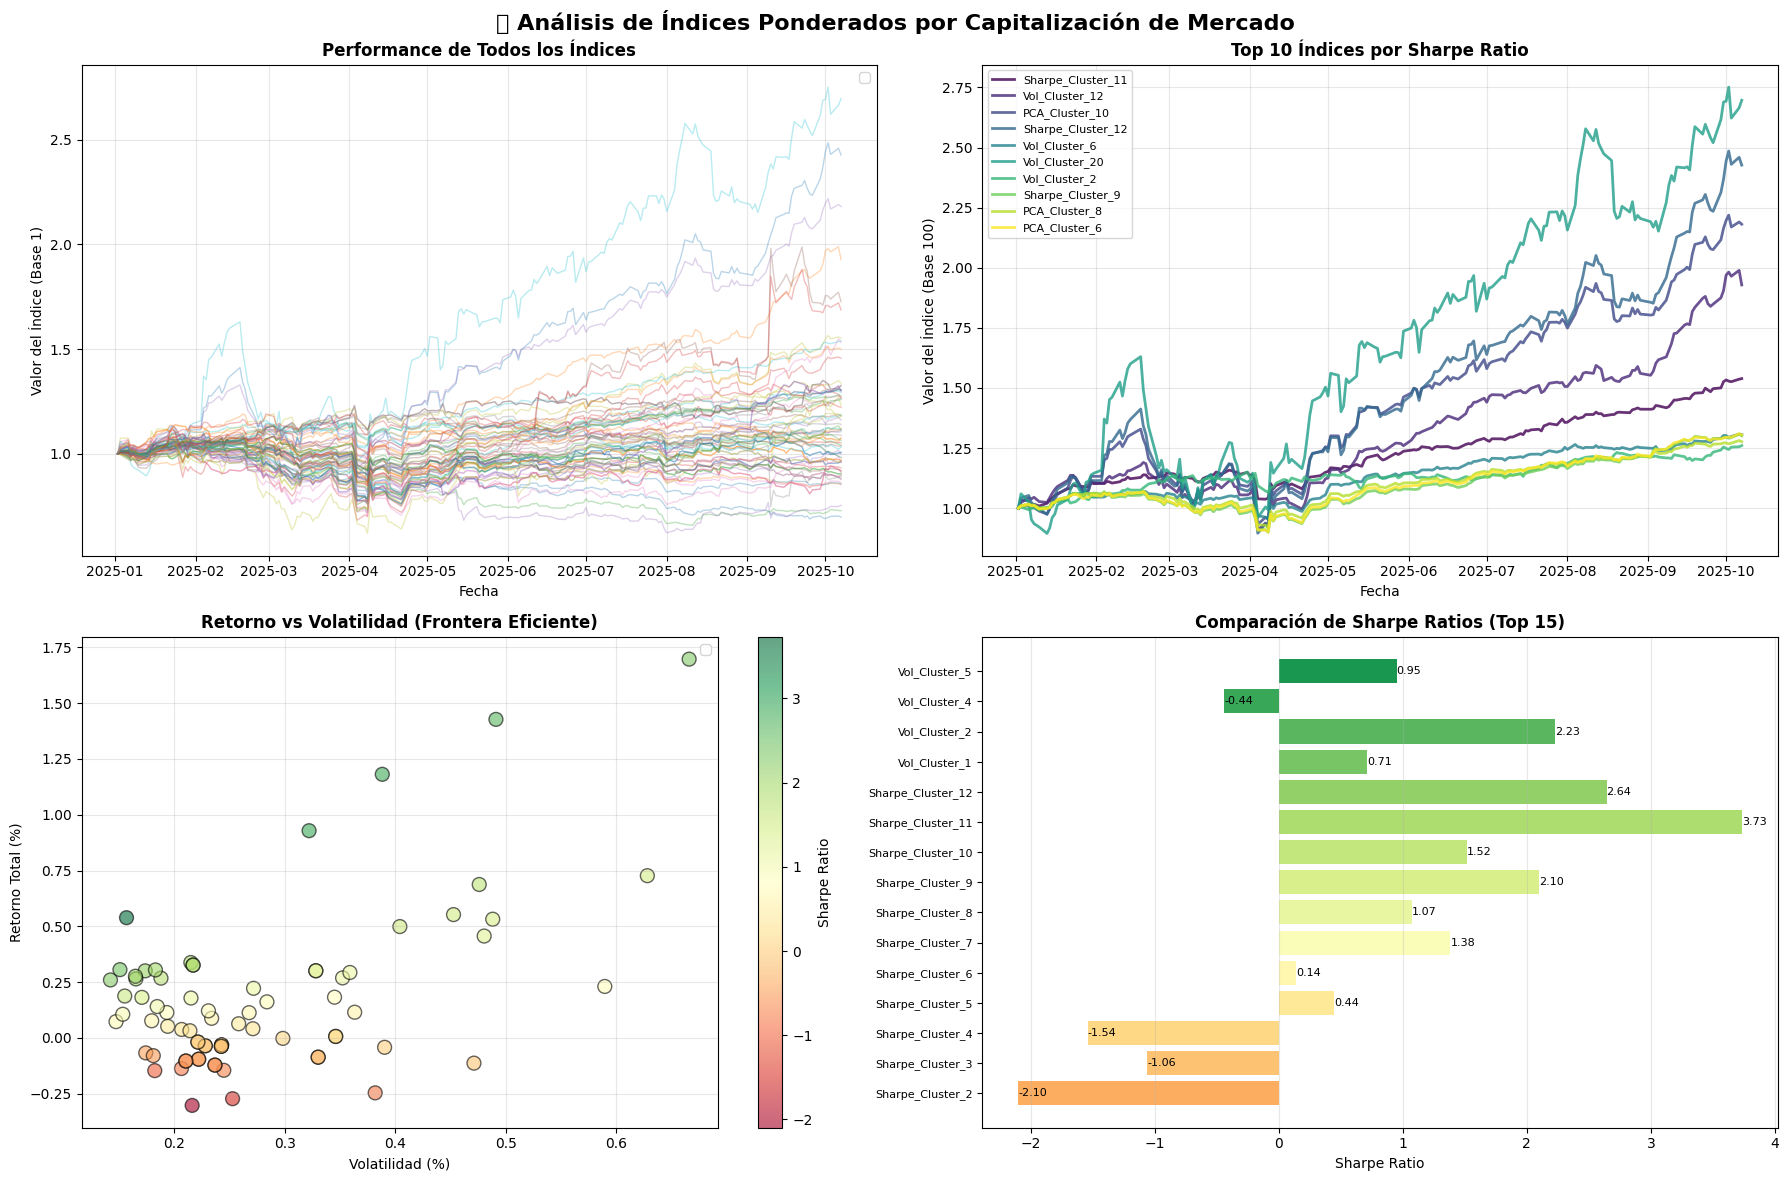



💾 Exportando resultados...
✅ Índices exportados a: cluster_indices_market_cap_weighted.csv
   Dimensiones: (191, 75)
✅ Métricas exportadas a: cluster_indices_market_cap_weighted_metrics.csv


In [62]:

# Paso 4: Visualizar los índices
print("\n\n📊 Generando visualizaciones...")
plot_cluster_indices(
    cluster_indices=cluster_indices,
    benchmark_ticker='SPY',
    data=tickers_data,
    top_n=10
)

# Paso 5: Exportar a CSV
print("\n\n💾 Exportando resultados...")
indices_df, metrics_df = export_cluster_indices_to_csv(
    cluster_indices=cluster_indices,filename='cluster_indices_market_cap_weighted.csv'
)


In [63]:

# Paso 5: Exportar a CSV
print("\n\n💾 Exportando resultados...")
indices_df, metrics_df = export_cluster_indices_to_csv(
    cluster_indices=cluster_indices,filename='cluster_indices_market_cap_weighted.csv'
)




💾 Exportando resultados...
✅ Índices exportados a: cluster_indices_market_cap_weighted.csv
   Dimensiones: (191, 75)
✅ Métricas exportadas a: cluster_indices_market_cap_weighted_metrics.csv


In [64]:

# Paso 6: Análisis del mejor cluster
print("\n" + "=" * 100)
print("  ANÁLISIS DETALLADO DEL MEJOR CLUSTER")
print("=" * 100)
## puedes cambiar cual cluster quieres ver, aqui quiero ver el mejor por Sharpe
best_cluster_name = summary_df.iloc[0]['Cluster']
best_cluster = cluster_indices[best_cluster_name]

print(f"\n🏆 Mejor Cluster: {best_cluster_name}")
print(f"   Tipo de análisis: {best_cluster['type']}")
print(f"   Número de tickers: {len(best_cluster['weights'])}")
print(f"\n📊 Métricas:")
print(f"   💰 Retorno Total: {best_cluster['metrics']['retorno_total']:.2f}%")
print(f"   📈 Volatilidad: {best_cluster['metrics']['volatilidad']:.2f}%")
print(f"   ⭐ Sharpe Ratio: {best_cluster['metrics']['sharpe_ratio']:.2f}")
print(f"   📉 Max Drawdown: {best_cluster['metrics']['max_drawdown']:.2f}%")
print(f"   💵 Valor Final: {best_cluster['metrics']['valor_final']:.2f}")

print(f"\n🏆 Composición del índice (Pesos por Capitalización):")
sorted_weights = sorted(best_cluster['weights'].items(), key=lambda x: x[1], reverse=True)
for i, (ticker, weight) in enumerate(sorted_weights, 1):
    if market_caps[ticker] > 0:
        market_cap_b = market_caps[ticker] / 1e9  # Convertir a billones
        print(f"   {i:2d}. {ticker:6s}: {weight*1:6.2f}% (Cap: ${market_cap_b:8.2f}B)")
    else:
        print(f"   {i:2d}. {ticker:6s}: {weight*1:6.2f}%")

print("\n" + "=" * 100)
print("✅ Análisis completado exitosamente")
print("=" * 100)


  ANÁLISIS DETALLADO DEL MEJOR CLUSTER

🏆 Mejor Cluster: Sharpe_Cluster_11
   Tipo de análisis: Sharpe Ratio
   Número de tickers: 22

📊 Métricas:
   💰 Retorno Total: 0.54%
   📈 Volatilidad: 0.16%
   ⭐ Sharpe Ratio: 3.73
   📉 Max Drawdown: -0.10%
   💵 Valor Final: 1.54

🏆 Composición del índice (Pesos por Capitalización):
    1. JNJ   :   0.19% (Cap: $  460.40B)
    2. GE    :   0.13% (Cap: $  318.26B)
    3. RTX   :   0.09% (Cap: $  210.15B)
    4. APH   :   0.06% (Cap: $  153.35B)
    5. KLAC  :   0.06% (Cap: $  143.14B)
    6. WELL  :   0.05% (Cap: $  115.27B)
    7. MO    :   0.05% (Cap: $  108.97B)
    8. CVS   :   0.04% (Cap: $  102.32B)
    9. HCA   :   0.04% (Cap: $   98.34B)
   10. GD    :   0.04% (Cap: $   89.32B)
   11. HWM   :   0.03% (Cap: $   77.51B)
   12. BK    :   0.03% (Cap: $   76.82B)
   13. GLW   :   0.03% (Cap: $   74.20B)
   14. TEL   :   0.03% (Cap: $   65.80B)
   15. AEP   :   0.03% (Cap: $   63.39B)
   16. COR   :   0.03% (Cap: $   61.97B)
   17. LHX   :   0.

### Análisis por sector del mejor cluster

In [65]:
# mostramos información basica de cada ticker en el mejor cluster
print(f"\n🏆 Información detallada de los tickers en el mejor cluster ({best_cluster_name}):")
for ticker in best_cluster['weights'].keys():
    # Calcular métricas específicas para cada ticker
    if ticker in tickers_data.columns:
        ticker_prices = tickers_data[ticker].dropna()
        if len(ticker_prices) > 1:
            ticker_returns = ticker_prices.pct_change().dropna()
            
            # Calcular métricas individuales del ticker
            ticker_retorno = (ticker_prices.iloc[-1] / ticker_prices.iloc[0] - 1) * 100
            ticker_volatilidad = ticker_returns.std() * np.sqrt(252) * 100
            ticker_sharpe = (ticker_returns.mean() / ticker_returns.std() * np.sqrt(252)) if ticker_returns.std() > 0 else 0
            
            print(f"   - {ticker}")
            print(f"      Retorno: {ticker_retorno:.2f}%")
            print(f"      Volatilidad: {ticker_volatilidad:.2f}%")
            print(f"      Sharpe Ratio: {ticker_sharpe:.2f}")
            print(f"      Sector: {ticker_info_db[ticker]['sector']}")
            print(f"      Industria: {ticker_info_db[ticker]['industry']}")
        else:
            print(f"   - {ticker}: No hay suficientes datos")
    else:
        print(f"   - {ticker}: No encontrado en tickers_data")
    


🏆 Información detallada de los tickers en el mejor cluster (Sharpe_Cluster_11):
   - AEP
      Retorno: 31.96%
      Volatilidad: 19.65%
      Sharpe Ratio: 1.97
      Sector: Utilities
      Industria: Utilities - Regulated Electric
   - APH
      Retorno: 81.49%
      Volatilidad: 37.25%
      Sharpe Ratio: 2.31
      Sector: Technology
      Industria: Electronic Components
   - ATO
      Retorno: 28.59%
      Volatilidad: 17.91%
      Sharpe Ratio: 1.95
      Sector: Utilities
      Industria: Utilities - Regulated Gas
   - BK
      Retorno: 40.50%
      Volatilidad: 25.27%
      Sharpe Ratio: 1.91
      Sector: Financial Services
      Industria: Banks - Diversified
   - CNP
      Retorno: 27.52%
      Volatilidad: 17.44%
      Sharpe Ratio: 1.94
      Sector: Utilities
      Industria: Utilities - Regulated Electric
   - COR
      Retorno: 38.20%
      Volatilidad: 22.98%
      Sharpe Ratio: 1.98
      Sector: Healthcare
      Industria: Medical Distribution
   - CVS
      Retor

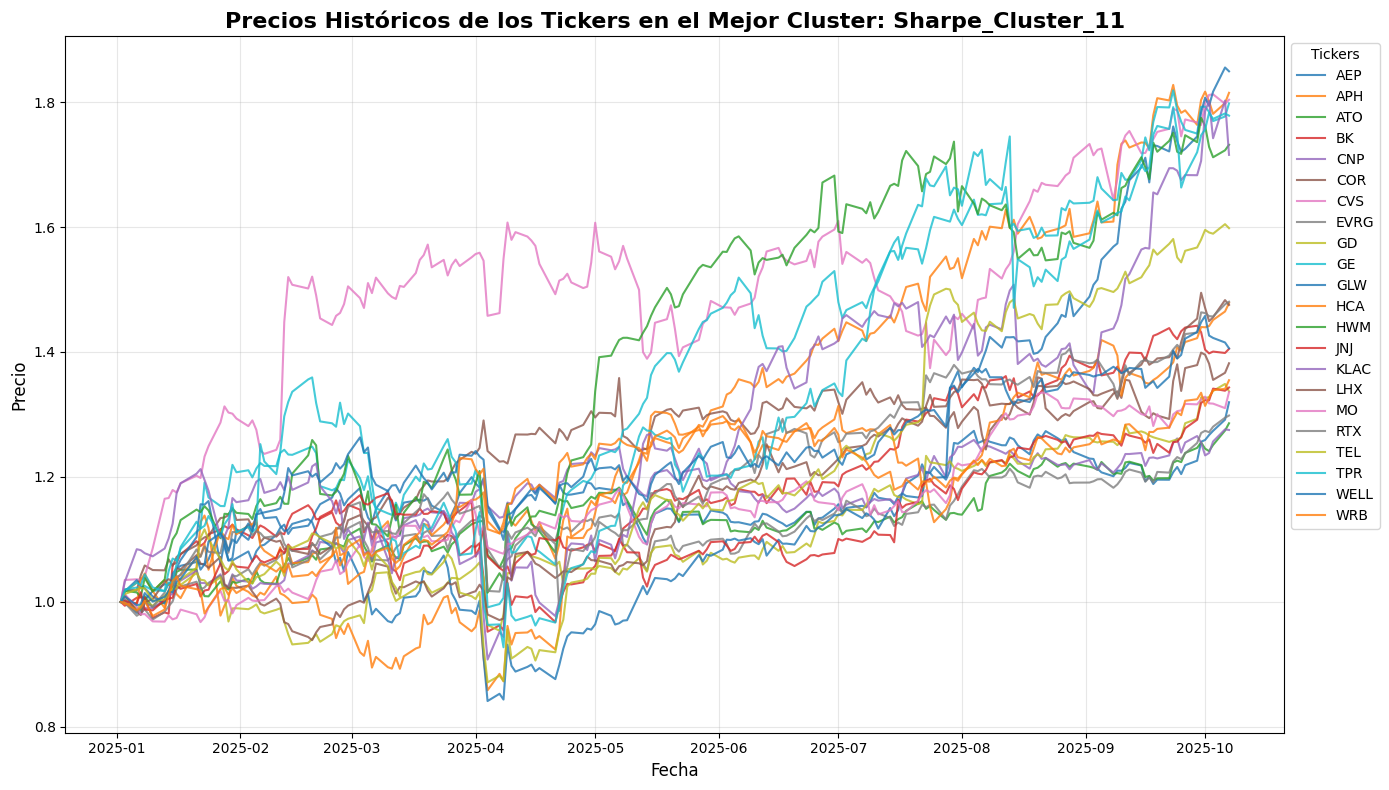

In [66]:
# Graficamos todos los tickers del mejor cluster en un solo gráfico
def plot_best_cluster_tickers(best_cluster_name, best_cluster, tickers_data):
    """
    Grafica los precios históricos de todos los tickers en el mejor cluster.

    Parámetros:
    -----------
    best_cluster_name : str
        Nombre del mejor cluster.
    best_cluster : dict
        Diccionario con información del mejor cluster, incluyendo los pesos y tickers.
    tickers_data : pd.DataFrame
        DataFrame con precios históricos de los tickers.
    """
    import matplotlib.pyplot as plt

    # Extraer los tickers del mejor cluster
    tickers = best_cluster['weights'].keys()

    # Crear la figura
    plt.figure(figsize=(14, 8))
    for ticker in tickers:
        if ticker in tickers_data.columns:
            plt.plot(tickers_data[ticker]/tickers_data[ticker].iloc[0], label=ticker, linewidth=1.5, alpha=0.8)
        else:
            print(f"⚠ Ticker {ticker} no encontrado en tickers_data")

    # Configurar el gráfico
    plt.title(f"Precios Históricos de los Tickers en el Mejor Cluster: {best_cluster_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Precio", fontsize=12)
    plt.legend(title="Tickers", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_best_cluster_tickers(best_cluster_name, best_cluster, tickers_data)

#### Gráfica de Validación (Período fuera de muestra)

📊 Período de validación: 2025-07-08 00:00:00 hasta 2025-10-07 00:00:00
   Total de días: 65


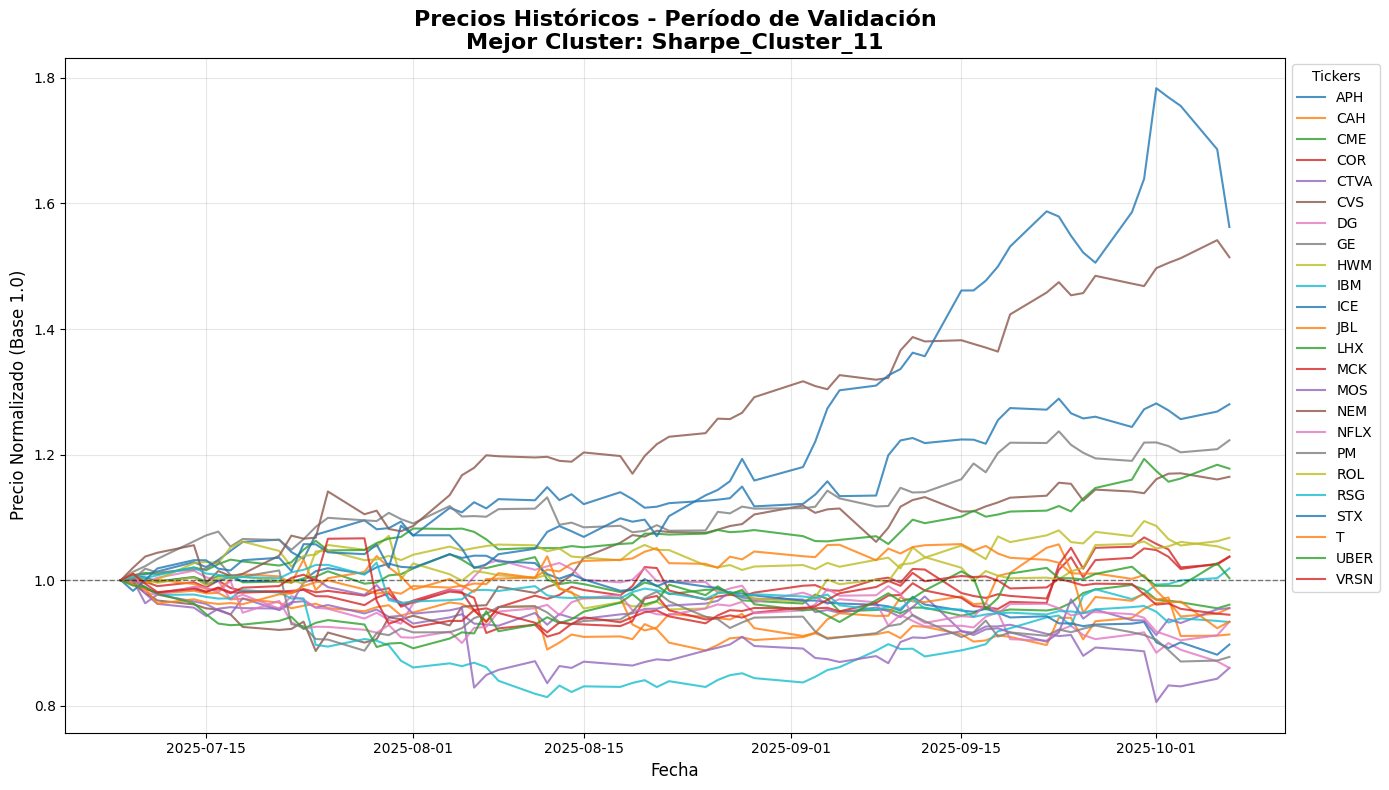


✅ Graficados 24 tickers

📈 RETORNOS EN PERÍODO DE VALIDACIÓN:
   STX   :  +56.24%
   NEM   :  +51.43%
   APH   :  +28.02%
   GE    :  +22.29%
   LHX   :  +17.76%
   CVS   :  +16.46%
   HWM   :   +6.76%
   ROL   :   +4.78%
   COR   :   +3.78%
   MCK   :   +3.72%
   IBM   :   +1.87%
   UBER  :   +0.33%
   CME   :   -3.91%
   CAH   :   -4.43%
   MOS   :   -4.44%
   VRSN  :   -5.50%
   T     :   -6.61%
   NFLX  :   -6.61%
   RSG   :   -6.66%
   JBL   :   -8.64%
   ICE   :  -10.25%
   PM    :  -12.22%
   DG    :  -13.96%
   CTVA  :  -13.97%

   📊 Retorno promedio del cluster: +4.84%


In [104]:
def plot_best_cluster_tickers_validation(best_cluster_name, best_cluster, validation_data):
    """
    Grafica los precios históricos de todos los tickers en el mejor cluster 
    durante el período de validación (fuera de muestra).

    Parámetros:
    -----------
    best_cluster_name : str
        Nombre del mejor cluster.
    best_cluster : dict
        Diccionario con información del mejor cluster, incluyendo los pesos y tickers.
    validation_data : pd.DataFrame
        DataFrame con precios históricos del período de validación.
    """
    import matplotlib.pyplot as plt

    # Extraer los tickers del mejor cluster
    tickers = best_cluster['weights'].keys()

    # Verificar que hay datos
    if len(validation_data) == 0:
        print("⚠️ No hay datos en el período de validación")
        return

    print(f"📊 Período de validación: {validation_data.index[0]} hasta {validation_data.index[-1]}")
    print(f"   Total de días: {len(validation_data)}")

    # Crear la figura
    plt.figure(figsize=(14, 8))
    
    tickers_plotted = 0
    ticker_performance = []
    
    for ticker in tickers:
        if ticker in validation_data.columns:
            ticker_data = validation_data[ticker].dropna()
            if len(ticker_data) > 1:
                # Normalizar usando el primer valor disponible
                normalized = ticker_data / ticker_data.iloc[0]
                plt.plot(normalized, label=ticker, linewidth=1.5, alpha=0.8)
                tickers_plotted += 1
                
                # Calcular retorno en el período de validación
                final_return = (ticker_data.iloc[-1] / ticker_data.iloc[0] - 1) * 100
                ticker_performance.append((ticker, final_return))
            else:
                print(f"⚠️ {ticker} no tiene suficientes datos en este período")
        else:
            print(f"⚠️ Ticker {ticker} no encontrado en validation_data")

    if tickers_plotted == 0:
        print("❌ No se pudo graficar ningún ticker")
        return

    # Configurar el gráfico
    plt.title(f"Precios Históricos - Período de Validación\nMejor Cluster: {best_cluster_name}", 
              fontsize=16, fontweight='bold')
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Precio Normalizado (Base 1.0)", fontsize=12)
    plt.legend(title="Tickers", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.3)
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Base')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Graficados {tickers_plotted} tickers")
    
    # Mostrar performance en validación
    print(f"\n📈 RETORNOS EN PERÍODO DE VALIDACIÓN:")
    ticker_performance.sort(key=lambda x: x[1], reverse=True)
    for ticker, ret in ticker_performance:
        print(f"   {ticker:6s}: {ret:+7.2f}%")
    
    avg_return = sum([r for _, r in ticker_performance]) / len(ticker_performance) if ticker_performance else 0
    print(f"\n   📊 Retorno promedio del cluster: {avg_return:+.2f}%")


# Graficar período de validación
plot_best_cluster_tickers_validation(best_cluster_name, best_cluster, validation_data)

#### Gráfica del Índice en Período de Validación


📊 Creando índice del mejor cluster para el período de validación...

📈 MÉTRICAS DEL ÍNDICE EN PERÍODO DE VALIDACIÓN:
   💰 Retorno Total: +4.53%
   📊 Volatilidad: 9.05%
   ⭐ Sharpe Ratio: 1.97
   📉 Max Drawdown: -3.39%
   💵 Valor Final: 1.0453


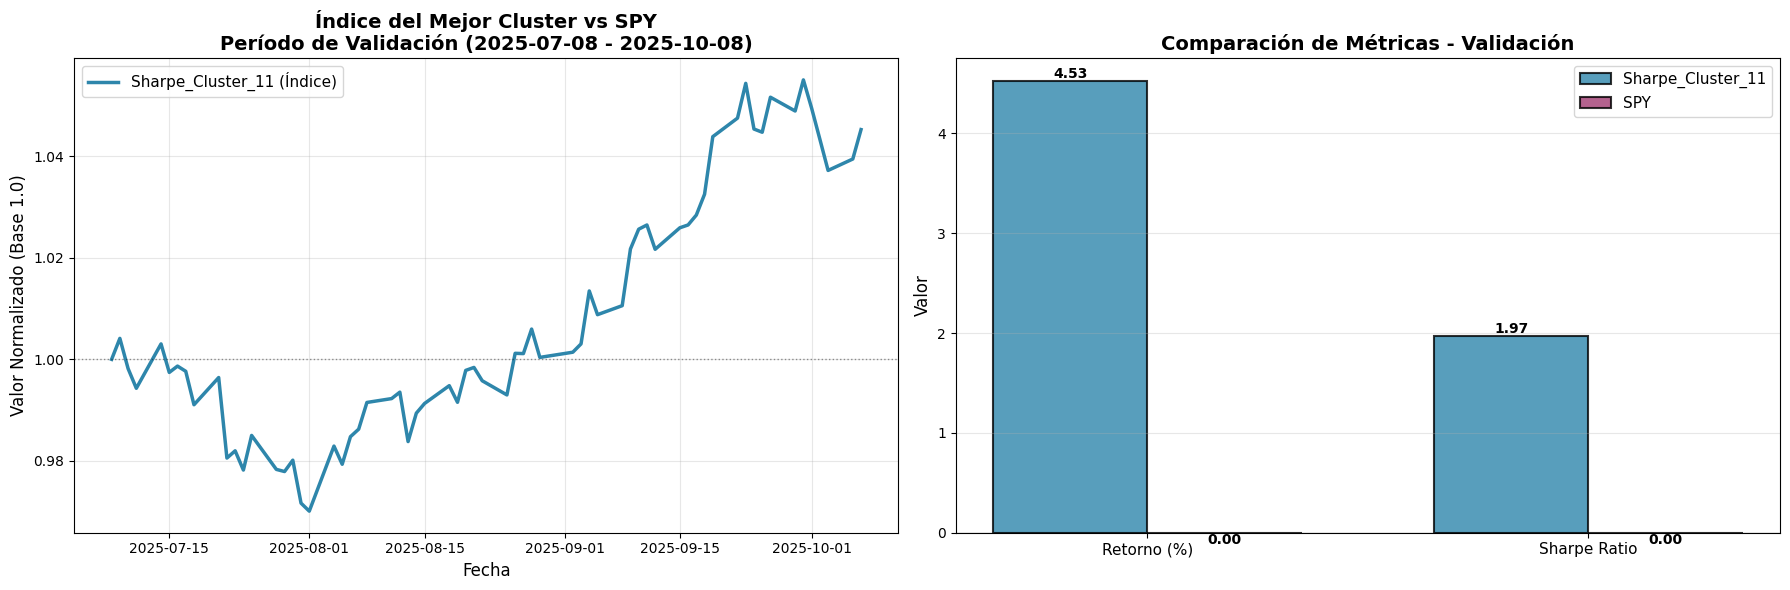


✅ Índice del mejor cluster evaluado en período de validación


In [105]:
# Crear y graficar el índice ponderado del mejor cluster en el período de validación
print("\n📊 Creando índice del mejor cluster para el período de validación...")

# Crear el índice ponderado para el período de validación
validation_index, validation_weights = create_market_cap_weighted_index(
    cluster_tickers=list(best_cluster['weights'].keys()),
    data=validation_data,
    market_caps_dict=market_caps,
    start_value=1
)

if validation_index is not None:
    # Calcular métricas del índice en validación
    validation_returns = validation_index.pct_change().dropna()
    
    validation_total_return = (validation_index.iloc[-1] / validation_index.iloc[0] - 1) * 100
    validation_volatility = validation_returns.std() * np.sqrt(252) * 100
    validation_sharpe = (validation_returns.mean() / validation_returns.std() * np.sqrt(252)) if validation_returns.std() > 0 else 0
    validation_max_drawdown = ((validation_index / validation_index.cummax()) - 1).min() * 100
    
    print(f"\n📈 MÉTRICAS DEL ÍNDICE EN PERÍODO DE VALIDACIÓN:")
    print(f"   💰 Retorno Total: {validation_total_return:+.2f}%")
    print(f"   📊 Volatilidad: {validation_volatility:.2f}%")
    print(f"   ⭐ Sharpe Ratio: {validation_sharpe:.2f}")
    print(f"   📉 Max Drawdown: {validation_max_drawdown:.2f}%")
    print(f"   💵 Valor Final: {validation_index.iloc[-1]:.4f}")
    
    # Crear gráfica comparativa
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Subplot 1: Índice vs SPY en validación
    ax1.plot(validation_index, linewidth=2.5, label=f'{best_cluster_name} (Índice)', color='#2E86AB')
    
    # Agregar SPY si está disponible
    if 'SPY' in validation_data.columns:
        spy_validation = validation_data['SPY'].dropna()
        spy_normalized = spy_validation / spy_validation.iloc[0]
        ax1.plot(spy_normalized, linewidth=2.5, label='SPY (S&P 500)', 
                color='#A23B72', linestyle='--', alpha=0.8)
        
        # Calcular métricas de SPY
        spy_returns = spy_validation.pct_change().dropna()
        spy_total_return = (spy_validation.iloc[-1] / spy_validation.iloc[0] - 1) * 100
        spy_sharpe = (spy_returns.mean() / spy_returns.std() * np.sqrt(252)) if spy_returns.std() > 0 else 0
        
        print(f"\n📊 COMPARACIÓN CON SPY:")
        print(f"   SPY Retorno: {spy_total_return:+.2f}%")
        print(f"   SPY Sharpe: {spy_sharpe:.2f}")
        print(f"   Diferencia de retorno: {validation_total_return - spy_total_return:+.2f}%")
    
    ax1.axhline(y=1.0, color='black', linestyle=':', linewidth=1, alpha=0.4)
    ax1.set_title(f'Índice del Mejor Cluster vs SPY\nPeríodo de Validación ({AN_DATE} - {END_DATE})', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fecha', fontsize=12)
    ax1.set_ylabel('Valor Normalizado (Base 1.0)', fontsize=12)
    ax1.legend(fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Comparación de métricas (barras)
    metrics_comparison = {
        'Retorno (%)': [validation_total_return, spy_total_return if 'SPY' in validation_data.columns else 0],
        'Sharpe Ratio': [validation_sharpe, spy_sharpe if 'SPY' in validation_data.columns else 0]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    cluster_values = [validation_total_return, validation_sharpe]
    spy_values = [spy_total_return if 'SPY' in validation_data.columns else 0, 
                  spy_sharpe if 'SPY' in validation_data.columns else 0]
    
    bars1 = ax2.bar(x - width/2, cluster_values, width, label=best_cluster_name, 
                    color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax2.bar(x + width/2, spy_values, width, label='SPY', 
                    color='#A23B72', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax2.set_title('Comparación de Métricas - Validación', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Valor', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Retorno (%)', 'Sharpe Ratio'], fontsize=11)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    
    # Añadir valores en las barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom' if height > 0 else 'top', 
                    fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"✅ Índice del mejor cluster evaluado en período de validación")
    print(f"{'='*80}")
    
else:
    print("❌ No se pudo crear el índice para el período de validación")

In [ ]:
# grafica del mejor cluster


## Mapper basado en ticker_info_db

### Preparar datos fundamentales

In [67]:
# Extraer características fundamentales de ticker_info_db
print("🔍 Extrayendo características fundamentales...")

fundamental_features = ['market_cap', 'beta', 'pe_ratio', 'dividend_yield', 
                       'profit_margins', 'roe', 'debt_to_equity', 'revenue_growth']

fundamental_data = []
fundamental_ticker_names = []

for ticker in ticker_names:
    if ticker in ticker_info_db:
        try:
            row = [ticker_info_db[ticker].get(feature, 0) for feature in fundamental_features]
            # Reemplazar None por 0
            row = [0 if x is None else x for x in row]
            fundamental_data.append(row)
            fundamental_ticker_names.append(ticker)
        except Exception as e:
            print(f"⚠️ Error con {ticker}: {e}")

# Convertir a DataFrame y normalizar
fundamental_df = pd.DataFrame(fundamental_data, columns=fundamental_features, index=fundamental_ticker_names)
print(f"✅ Datos fundamentales extraídos: {fundamental_df.shape}")

# Normalizar datos
scaler_fundamental = StandardScaler()
fundamental_scaled = scaler_fundamental.fit_transform(fundamental_df.fillna(0))

print(f"📊 Datos preparados: {fundamental_scaled.shape[0]} tickers, {fundamental_scaled.shape[1]} características")

🔍 Extrayendo características fundamentales...
✅ Datos fundamentales extraídos: (503, 8)
📊 Datos preparados: 503 tickers, 8 características


### Crear Mapper con datos fundamentales

In [68]:
# Crear mapper con datos fundamentales
mapper_fundamental = km.KeplerMapper(verbose=1)

# Proyección PCA
projected_fundamental = mapper_fundamental.fit_transform(fundamental_scaled, projection='sum')

# Crear grafo
covering_fundamental = km.Cover(n_cubes=7, perc_overlap=0.4)
G_fundamental = mapper_fundamental.map(projected_fundamental, fundamental_scaled,
                                       clusterer=sklearn.cluster.KMeans(n_clusters=3),
                                       cover=covering_fundamental)

# Visualizar
mapper_fundamental.visualize(G_fundamental,
                            title='Mapper: Análisis Fundamental (ticker_info_db)',
                            custom_tooltips=np.array(fundamental_ticker_names),
                            path_html='visualizaciones_mapper_indice/mapper_fundamental.html')

print(f"✅ Mapper fundamental creado: {len(G_fundamental['nodes'])} nodos, {len(G_fundamental['links'])} aristas")

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (503, 8)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (503, 8) using lens shaped (503, 1)

Creating 7 hypercubes.

Created 23 edges and 21 nodes in 0:00:00.033468.
Wrote visualization to: visualizaciones_mapper_indice/mapper_fundamental.html
✅ Mapper fundamental creado: 21 nodos, 15 aristas


### Extraer clusters del Mapper fundamental

In [69]:
# Extraer clusters del Mapper fundamental
print("📊 Extrayendo clusters del Mapper fundamental...")

fundamental_clusters = {}

for i, (node_name, node_indices) in enumerate(G_fundamental['nodes'].items()):
    if len(node_indices) >= 2:
        cluster_tickers = [fundamental_ticker_names[idx] for idx in node_indices]
        cluster_name = f"Fundamental_Cluster_{i+1}"
        fundamental_clusters[cluster_name] = {
            'tickers': cluster_tickers,
            'type': 'Fundamental',
            'node_name': node_name,
            'size': len(cluster_tickers)
        }
        print(f"   {cluster_name}: {len(cluster_tickers)} tickers")

print(f"\n✅ {len(fundamental_clusters)} clusters fundamentales encontrados")

📊 Extrayendo clusters del Mapper fundamental...
   Fundamental_Cluster_1: 2 tickers
   Fundamental_Cluster_3: 3 tickers
   Fundamental_Cluster_4: 116 tickers
   Fundamental_Cluster_5: 120 tickers
   Fundamental_Cluster_6: 112 tickers
   Fundamental_Cluster_7: 164 tickers
   Fundamental_Cluster_8: 141 tickers
   Fundamental_Cluster_9: 132 tickers
   Fundamental_Cluster_10: 37 tickers
   Fundamental_Cluster_11: 7 tickers
   Fundamental_Cluster_12: 14 tickers
   Fundamental_Cluster_13: 4 tickers
   Fundamental_Cluster_14: 4 tickers
   Fundamental_Cluster_20: 2 tickers

✅ 14 clusters fundamentales encontrados


### Crear índices para clusters fundamentales

In [70]:
# Crear índices para clusters fundamentales
fundamental_indices = create_all_cluster_indices(
    all_clusters=fundamental_clusters,
    data=tickers_data,
    market_caps_dict=market_caps,
    start_value=1
)

# Crear resumen
fundamental_summary = []
for cluster_name, cluster_data in fundamental_indices.items():
    fundamental_summary.append({
        'Cluster': cluster_name,
        'Tickers': cluster_data['metrics']['num_tickers'],
        'Retorno (%)': cluster_data['metrics']['retorno_total'],
        'Volatilidad (%)': cluster_data['metrics']['volatilidad'],
        'Sharpe Ratio': cluster_data['metrics']['sharpe_ratio'],
        'Max Drawdown (%)': cluster_data['metrics']['max_drawdown']
    })

fundamental_summary_df = pd.DataFrame(fundamental_summary)
fundamental_summary_df = fundamental_summary_df.sort_values('Sharpe Ratio', ascending=False)

print("\n📊 TOP ÍNDICES FUNDAMENTALES:")
print(fundamental_summary_df.to_string(index=False))


📊 TOP ÍNDICES FUNDAMENTALES:
               Cluster  Tickers  Retorno (%)  Volatilidad (%)  Sharpe Ratio  Max Drawdown (%)
Fundamental_Cluster_13        4     1.083993         0.615345      1.890128         -0.430699
Fundamental_Cluster_10       37     0.441147         0.289643      1.818283         -0.256064
 Fundamental_Cluster_3        3     0.698979         0.532310      1.579248         -0.291540
 Fundamental_Cluster_4      116     0.124595         0.138991      1.190439         -0.094326
Fundamental_Cluster_14        4     0.222353         0.261838      1.146002         -0.246693
 Fundamental_Cluster_5      120     0.125842         0.156294      1.083774         -0.106722
 Fundamental_Cluster_9      132     0.148254         0.187526      1.071216         -0.161753
Fundamental_Cluster_20        2     0.336858         0.525518      0.996176         -0.366946
 Fundamental_Cluster_8      141     0.198075         0.279600      0.995223         -0.269855
 Fundamental_Cluster_7      16

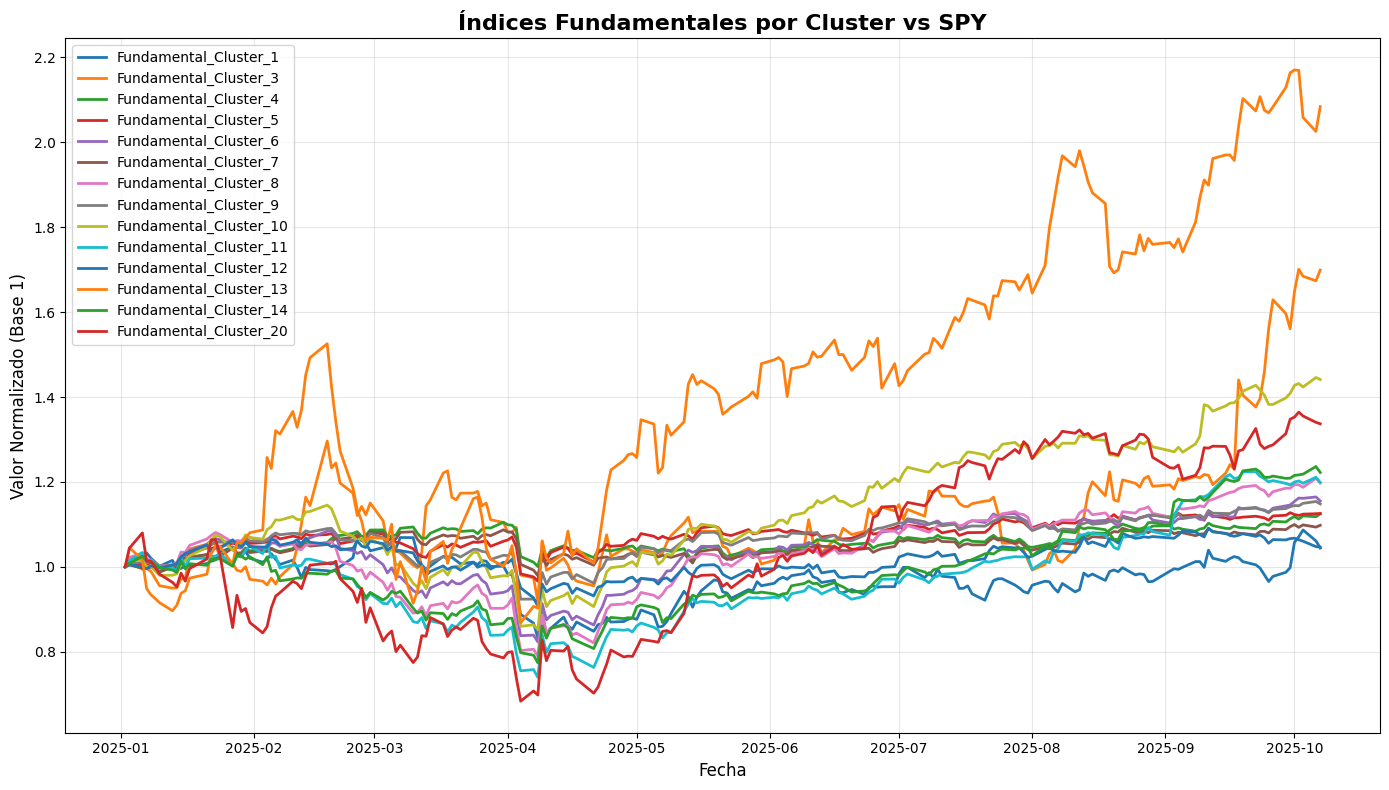

In [71]:
import matplotlib.pyplot as plt

# Graficar todos los índices fundamentales
plt.figure(figsize=(14, 8))

for cluster_name, cluster_data in fundamental_indices.items():
    index_series = cluster_data['index']
    plt.plot(index_series, linewidth=2, label=cluster_name)

# Comparar con SPY
if 'SPY' in tickers_data.columns:
    spy_normalized = (tickers_data['SPY'] / tickers_data['SPY'].iloc[0]) * 1
    plt.plot(spy_normalized, linewidth=2, linestyle='--', alpha=0.7, label='SPY', color='black')

plt.title('Índices Fundamentales por Cluster vs SPY', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valor Normalizado (Base 1)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
